In [2]:
from scipy.integrate import odeint
import math 
import numpy as np
import matplotlib.pyplot as plt
import theano
%matplotlib inline
theano.config.exception_verbosity= 'high'
THEANO_FLAGS='optimizer=fast_compile'

# Black-Box Variational Inference for ODEs

Most probabilistic programming packages support blackbox variation inference (BBVI) using the underlying automatic differentiation library. BBVI is driving the latest developments in deep unsupervised learning and pretty much everything behind probabilistic interpretations of a deep net. This is also the algorithm used to train VAEs. In this tutorial I would use BBVI, to be specific a version of BBVI, for inference in the [Fitzhugh Nagumo model](http://www.scholarpedia.org/article/FitzHugh-Nagumo_model), a simplified ODE model of a neuron. I chose this deliberately so that we can revisit the past (in terms of understanding the brain) using tools of the future. 

I think BBVI has the potential for significant impact in physical sciences and can act as a vehicle to integrate our prior understanding of physics to data in the most efficient way. I would briefly mention here the basics of BBVI. However, a complete introduction in this topic is beyond the scope and I would strongly recomend [Christopher Bishop's classic texbook (chapter 10)](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book) or [Prof Mackay's](https://www.youtube.com/watch?v=rkV6Wu30x4g&list=PLruBu5BI5n4aFpG32iMbdWoRVAA-Vcso6&index=14) excellent video tutorials for a wider introduction to classic variational inference.

But before I start explaining BBVI let me first quickly setup our model. Note that in this example I would put different priors on the parameters and thus I setup the Theano wrapper to handle that. The chosen model is the Fitzhugh-Nagumo model setup in the action potential regime.

$$ 
\begin{aligned}
\frac{dV}{dt} &= (V -\frac{V^3}{3} +R)c \\
\frac{dR}{dt} &= \frac{(V -a+bR)}{c}
\end{aligned}
$$

Parameter vector $\theta =\{a,b,c\}$

In [90]:
class FitzhughNagumoModel(object):

    def __init__(self, y0=None):

        if y0 is None:
            self._y0 = np.array([-1, 1], dtype=float)
        else:
            self._y0 = np.array(y0, dtype=float)
            
    def simulate(self, parameters, times):
        return self._simulate(parameters, times, False)

    def simulate_with_sensitivities(self, parameters, times):
        return self._simulate(parameters, times, True)

    def _simulate(self, parameters, times, sensitivities):
 
        a, b, c = [float(x) for x in parameters]
        times = np.asarray(times)

        def r(y, t, p):
            V, R = y
            dV_dt = (V - V**3 / 3 + R) * c
            dR_dt = -(V - a + b * R) /c
            return dV_dt, dR_dt

        if sensitivities:
            def jac(y):
                V, R = y
                ret = np.empty((2, 2))
                ret[0, 0] = c*(1-V**2)
                ret[0, 1] = c
                ret[1, 0] = -1 / c
                ret[1, 1] = -b / c
                return ret

            def dfdp(y):
                V, R = y
                ret = np.empty((2, 3))
                ret[0, 0] = 0
                ret[0, 1] = 0
                ret[0, 2] = R - V**3/3 + V
                ret[1, 0] = 1 / c
                ret[1, 1] = -R / c
                ret[1, 2] = (R * b + V - a) / c**2
                return ret

            def rhs(y_and_dydp, t, p):
                y = y_and_dydp[0:2]
                dydp = y_and_dydp[2:].reshape((2, 3))

                dydt = r(y, t, p)
                d_dydp_dt = np.matmul(jac(y), dydp) + dfdp(y)

                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))

            y0 = np.zeros(8)
            y0[0:2] = self._y0
            result = odeint(rhs, y0, times, (parameters,), rtol=1e-8, atol=1e-8)
            values = result[:, 0:2]
            dvalues_dp = result[:, 2:].reshape((len(times), 2, 3))
            return values, dvalues_dp
        else:
            values = odeint(r, self._y0, times, (parameters,), rtol=1e-8, atol=1e-8)
            return values
ode_model = FitzhughNagumoModel()

## Theano custom operation

In [5]:
class ODEGradop(theano.Op):
    def __init__(self,jac_sens):
        self.jac_sens = jac_sens

    def make_node(self, x, y, v):
        x = theano.tensor.as_tensor_variable(x)
        y = theano.tensor.as_tensor_variable(y)
        v = theano.tensor.as_tensor_variable(v)
        node = theano.Apply(self, [x, y, v], [v.type()])
        return node

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        y = inputs_storage[1]
        v = inputs_storage[2]
        out = output_storage[0]
        out[0] = np.asarray(self.jac_sens(x, y, v))

class ODEop(theano.Op):

    def __init__(self, state,jac_sens):
        self.state = state
        self.jac_sens =jac_sens

    def make_node(self, x, y):
        x = theano.tensor.as_tensor_variable(x)
        y = theano.tensor.as_tensor_variable(y)
        return theano.Apply(self, [x, y], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        y = inputs_storage[1]
        out = output_storage[0]
        
        out[0] = np.asarray(self.state(x, y))

    def grad(self, inputs, output_grads):

        x = inputs[0]
        y = inputs[1]
        v = output_grads[0]
        op = self
        grad_op = ODEGradop(self.jac_sens)
        grad_op_apply = grad_op(x, y, v)
        
        return [grad_op_apply[0:2], grad_op_apply[2]]

## Caching 

This is required so that the same ODE solution can be used during the backward pass. I think this is handled nicely in PyTorch, MXNet whereas Theano is a bit outdated. 

In [13]:
class solveCached(object):
    def __init__(self, times, n_params, n_outputs):
        
        self.times = times
        self.n_params = n_params
        self.n_outputs = n_outputs
        self.cachedParam = np.zeros(n_params)
        self.cachedJac = np.zeros((len(times), n_outputs, n_params))
        self.cachedState = np.zeros((len(times),n_outputs))
        
    def __call__(self, x):
        
        if np.all(x==self.cachedParam):
            state, jac = self.cachedState, self.cachedJac
            
        else:
            state, jac = ode_model.simulate_with_sensitivities(x, times)
        
        return state, jac
times = np.linspace(0, 10, 20)
cached_solver=solveCached(times, 3, 2)

## The non-symbolic vector Jacobain product

In deep net the automatic differentiation does this for you. But anyways we can do it using the sensitivity matrix.

In [29]:
def state(x, y):
    
    xy = np.concatenate([x.reshape(len(x)),y.reshape(1)])
    State, Jac = cached_solver(xy)
    cached_solver.cachedState, cached_solver.cachedJac, cached_solver.cachedParam = State, Jac, xy
    return State.reshape((2*len(State),))

def jac_sens(x, y, v):
    
    xy = np.concatenate([x.reshape(len(x)),y.reshape(1)])
    backProp = cached_solver(xy)[1].reshape((2*len(times),len(xy)))
    return backProp.T.dot(v)

# Fake data

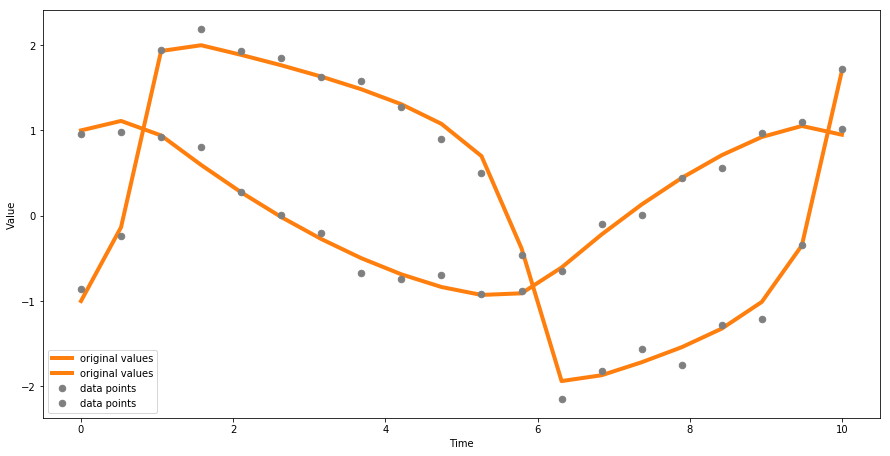

In [30]:
times = np.linspace(0, 10, 20)
sigma=0.1
real_params = [0.2,0.2,3.]
sol=ode_model.simulate(real_params, times)
Y=sol+np.random.randn(20,2)*sigma
plt.figure(figsize=(15, 7.5))
plt.plot(times, sol, '-', color='#ff7f0e', lw=4, label='original values')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')

# BBVI

Our inferential task consists of estimating the posterior density $p(\theta|Y)$ known upto a normalising constant $Z$. In this case $\theta =\{a,b,c,\sigma\}$. Using variational inference we can approximate $p(\theta|Y)$ with a tractable distribution $q(\theta|\lambda)$ from a family of distributions $\mathcal{Q}=\{q(\cdot|\lambda):\lambda\in\Lambda\}$ parametrized by $\lambda$. Variational methods minimise the KL-divergence given by
$$
\begin{aligned}
\mathrm{KL}(q(\theta|\lambda)||p(\theta|Y)) &= \int q(\theta|\lambda) \log \{ \frac{p(Y,\theta)}{q(\theta|\lambda)}\}d \theta \\
&=-(\mathbb{E}[\log p(Y|\theta)p(\theta)]-\mathbb{E}[\log q(\theta|\lambda)]) + \log Z
\end{aligned}
$$

between $q(\theta|\lambda)$ and the true posterior density as a function of the variational parameters $\lambda$ and where all expectations are taken with respect to $q(\theta|\lambda)$. Direct optimization of $\mathrm{KL}(q(\theta|\lambda)||p(\theta|Y))$ is intractable due to the dependence on $Z$. Alternatively, since $\log Z$ is a constant we can maximise the quantity within the brackets in the above equation. This quantity often referred to as the evidence lower bound (ELBO) is a tractable objective given by

$$
\mathcal{L}(\lambda)=\mathbb{E}[\log p(Y|\theta)p(\theta)]-\mathbb{E}[\log q(\theta|\lambda)].
$$

For a non-linear map $f:\mathbb{R}^d\rightarrow \mathbb{R}^k$, as in the case of a differential equation $\dot{x}=f(x,\theta), x(t) \in \mathbb{R}^k, \theta \in \mathbb{R}^d$, we have to approximate these expectations using [Monte Carlo](https://arxiv.org/abs/1401.0118).
Now we can maximise $\mathcal{L}(\lambda)$ using gradient descent by choosing some appropriate density function for $q$. Theano takes care of the gradients in most cases, except ODEs. This is why I created the custom op above

Although PyMC3 supports different approximations we will consider a factorised (among the components of $\theta$) variational approximation for this tutorial, which is also known as the mean-field approximation, where $q(\theta|\lambda)=\prod_{i=1}^{d}q(\theta_i|\lambda)$

## Related work

Variational inference was popularised in machine learning for inference in probabilistic graphical models, where one can take all the expectations analytically. However, for non-linear maps the Monte Carlo versions, BBVI, was made popular through deep learning applications such as unsupervised learning using deep generative models. One of the most popular deep generative model the variational autoencoder (VAE), read about this [here](https://arxiv.org/abs/1312.6114), uses BBVI to train. Recently BBVI is mostly used for training deep neural nets within the Bayesian framework. This is sometimes known as [Bayesian deep learning](http://bayesiandeeplearning.org/).

# Reparametrisation and transformations

Note that replacing expectations of the gradient with Monte Carlo estimates does not introduce bias but suffers from high variance. In order to reduce the variance [Kingma and Welling](https://arxiv.org/abs/1312.6114) introduced a stochastic regularisation technique where the approximate density is reparameterised as $q(\theta|\lambda)=g(\theta|\lambda)p(\epsilon)$ where $g(\theta|\lambda)$ is a deterministic transform parametrised by $\lambda$ and $\epsilon$ is a random number. For example if we have $q(\theta|\lambda)=\mathcal{N}(\theta;\mu,\sigma^2)$ where $\lambda=(\mu,\sigma)$, then we can reparameterise $q$ as $q(\theta|\lambda)=g(\lambda)p(\epsilon)$ where $g(\lambda)=\mu + \sigma\epsilon$ and $\epsilon\sim \mathcal{N}(0,1)$. Representing $q(\theta|\lambda)$ with non-centred parametrisation helps in reducing the variance of the Monte Carlo estimate of the expected gradients.

# From BBVI to ADVI in PyMC3

In [ADVI](https://arxiv.org/abs/1603.00788) the BBVI is modified in a way such that the supports of the target and approximate densities match. This is important when we use densities on positive reals. PyMC3 implements the ADVI algorithm.

Below we define the generative model and call the `pm.fit()` with the advi method. By default this uses a mean-field Nomral approximation. 

In [92]:
import pymc3 as pm
theano.config.floatX = 'float64'
theano.config.compute_test_value = 'ignore'

my_op = ODEop(state,jac_sens)

with pm.Model() as FN_model:

    # Priors for unknown model parameters
    ab = pm.HalfNormal('ab', sd=1, shape=2)
    c =  pm.Uniform('c', lower=1, upper=5)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Forward model
    forward=my_op(ab,c)
    mu = forward.reshape((20,2))

    # Likelihood (sampling distribution) of observations
    cov=np.eye(2)*sigma**2
    Y_obs = pm.MvNormal('Y_obs', mu=mu, cov=cov, observed=Y)
    
    # This callback is used to monitor the convergence of ELBO
    advi=pm.ADVI()
    tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval, std=advi.approx.std.eval ) 
    
    # Here we use 5 Monte Carlo samples for the expectation
    q_dist = pm.fit(2000,method='advi',obj_n_mc=5,
                      obj_optimizer=pm.adam(learning_rate=0.01),callbacks=[tracker])

Average Loss = -14.212: 100%|██████████| 2000/2000 [04:23<00:00,  6.94it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcdab45190>,
      dtype=object)

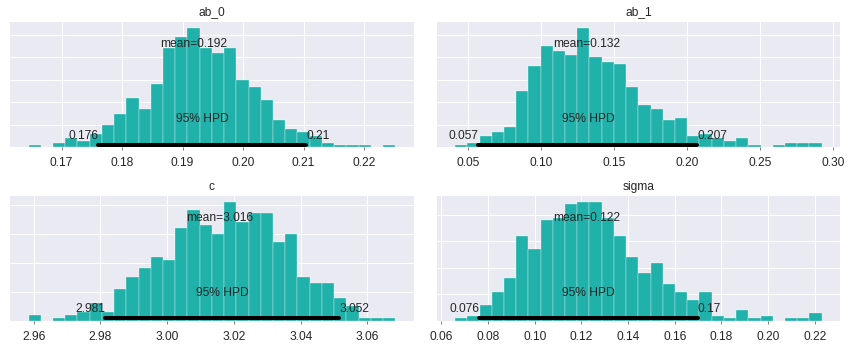

In [93]:
pm.plot_posterior(q_dist.sample(500), color='LightSeaGreen')

## Check the convergence of ELBO

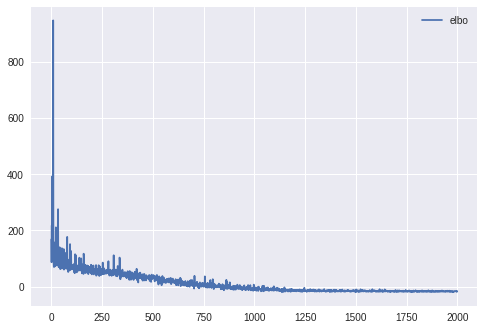

In [94]:
plt.plot(q_dist.hist, label='elbo')
plt.legend()

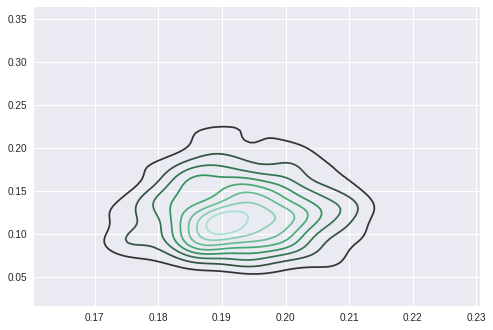

In [95]:
ab = q_dist.sample(500).get_values('ab')
import seaborn as sns
sns.kdeplot(ab)

In [91]:
# Assignment 1: As you can notice the mean-field approx. is not enough
#to capture the correlations. 
# One way to improve this is by using a fullrank Gaussian approximation. 
# Try out the `fullrank_advi` method for this.

#with FN_model:
#    q_dist_fullrank = pm.fit()

# Assignment 2: Some readers might get tempted to use the ELBO 
# as a proxy of marginal likelihood and then use that 
# in computing Bayes Factor. Using the lower bound as a proxy 
# is in general a bad idea. For model selection one can
# alternatively use the WAIC and the LOO scores. 
# Use different prior or likelihood for the same data and use PyMC3's
# WAIC, LOO and carry out model selection.

# What about TensorFlow, PyTorch

In tensorflow you can use the `py_func` for creating a custom python op. After that you can use [Edward](http://edwardlib.org/) or the latest [tensorflow probabiliy](https://github.com/tensorflow/probability) as the ppl. Also checkout tensorflow [distribution](https://arxiv.org/pdf/1711.10604.pdf) package which implements a bijector object that you will need for transforming densities to the real line. You can create a similar custom op in PyTorch and then use [Pyro](http://pyro.ai/) as the ppl. Infact it would be a great thing if one can embed some well know solver libraries such as CVODE as PyTorch [C++ extensions](https://pytorch.org/tutorials/advanced/cpp_extension.html#writing-a-c-extension). Just remember one thing that as long as you do the vector Jacobain product yourself you can seamlessly move between many existing and newer ppls for carrying out BBVI.